
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio ETL: Análisis del Sistema Energético en España

## Objetivo

Durante todos los laboratorios de esta semana realizarás un proceso completo de ETL para analizar la relación entre la demanda, el consumo y la generación eléctrica en diferentes provincias de España a lo largo de un año. Además, complementarán este análisis con datos demográficos y económicos extraídos del Instituto Nacional de Estadística (INE). El **objetivo principal** del análisis es **examinar cómo la demanda, el consumo y la generación eléctrica en diferentes provincias de España a lo largo de los años están influenciados por factores demográficos y económicos, como la población y el PIB provincial**. El análisis busca identificar patrones y correlaciones entre estas variables para comprender mejor las dinámicas energéticas regionales y su relación con el desarrollo socioeconómico en España.

Antes de realizar el análisis, vamos a definir las hipótesis con las que vamos a trabajar, las cuales definirán todo tu análisis y planteamiento de los laboratorios: 

- **Hipótesis 1: La demanda eléctrica está correlacionada con la población de la provincia.** Provincias con mayor población tienden a tener una mayor demanda eléctrica.
  
- **Hipótesis 2: El crecimiento económico (medido por el PIB) está correlacionado con la demanda eléctrica.** Las provincias con un PIB más alto o en crecimiento experimentan una mayor demanda de energía.

- **Hipótesis 3: La proporción de generación renovable está relacionada con factores económicos o geográficos.** Provincias con un mayor desarrollo económico o con condiciones geográficas favorables (como más horas de sol o viento) tienden a generar más energía renovable.


## Tareas Laboratorio Extracción

En el laboratorio de hoy tendrás que extraer la información necesaria para obtener tu objetivo de las siguientes fuentes de datos (deberás usar API's y herramientas de *web scrapping*):

- **Datos de la API de Red Eléctrica Española (REE):** Deberás extraer datos mensuales a nivel provincial de los siguientes aspectos:

  - **Demanda Eléctrica:** Nos proporciona los datos de demanda eléctrica a nivel provincial, agregados de manera mensual. Tendrás que usar el endpoint de "https://apidatos.ree.es/es/datos/demanda/evolucion", añadiendo los parámetros que sean necesarios. 

  - **Generación Eléctrica:** Nos proporciona los datos de generación eléctrica a nivel provincial, diferenciando entre fuentes de energía (eólica, solar, hidroeléctrica, etc.), agregados de manera mensual. Tendrás que usar el endpoint de "https://apidatos.ree.es/es/datos/generacion/estructura-renovables", añadiendo los parámetros que sean necesarios.

  La documentación de la API la encontrarás en [este link](https://www.ree.es/es/apidatos). Recuerda leer en detenimiento la documentación. 

- **Datos del Instituto Nacional de Estadística (INE):** Además de los datos de la REE, debes extraer y utilizar datos socioeconómicos de las siguientes páginas del INE:

- **Datos Demográficos:** Extraer los datos de población por provincias, diferenciando por grupos de edad, sexo, y extrajeros. Estos datos serán utilizados para analizar cómo la población afecta a la demanda eléctrica en cada provincia.

  - **Página web:** [INE - Población por provincias](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177012&menu=resultados&idp=1254734710990)

  - "Principales series 1998-2022" --> "Por provincia" --> " Población por provincias, edad (3 grupos de edad), españoles/Extranjeros, Sexo y año"

- **Datos Económicos:**

  - **Página web:** [INE - PIB por provincias](https://www.ine.es/dynt3/inebase/es/index.htm?padre=10426&capsel=10429). 

  - **Pasos para la extracción**:" Resultados provinciales. Serie contable 2016-2021" --> "P.I.B. a precios de mercado y valor añadido bruto a precios básicos por ramas de actividad: Precios corrientes por provincias y periodo."



NOTA1: Tienes que sacar muchos datos, pero recuerda que hemos aprendido herramientas de asincronia que te pueden ayudar en este paso de la ETL. 

NOTA2: Todos estos datos los debes sacar para los años 2019-2020-2021

In [9]:
from tqdm import tqdm
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import os
import re
from datetime import datetime

from src import support_llamadas_asincronas as sup_llam

In [2]:
cod_comunidades = {'Ceuta': 8744,
                    'Melilla': 8745,
                    'Andalucía': 4,
                    'Aragón': 5,
                    'Cantabria': 6,
                    'Castilla - La Mancha': 7,
                    'Castilla y León': 8,
                    'Cataluña': 9,
                    'País Vasco': 10,
                    'Principado de Asturias': 11,
                    'Comunidad de Madrid': 13,
                    'Comunidad Foral de Navarra': 14,
                    'Comunitat Valenciana': 15,
                    'Extremadura': 16,
                    'Galicia': 17,
                    'Illes Balears': 8743,
                    'Canarias': 8742,
                    'Región de Murcia': 21,
                    'La Rioja': 20}

anios = ['2019', '2020', '2021']

headers = {
    'Accept': 'application/json;',
    'Content-Type': 'application/json',
    'Host': 'apidatos.ree.es'
}

## Construimos las urls de las que tenemos que obtener la informacion para la 'demanda energetica'.

In [3]:
urls = []

for clave, valor in tqdm(cod_comunidades.items()):
    for anio in anios:
        urls.append({
            'cod_comunidad': valor,
            'nombre_comunidad': clave,
            'anio': anio,
            'url': f'https://apidatos.ree.es/es/datos/demanda/evolucion?start_date={anio}-01-01T00:00&end_date={anio}-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids={valor}'
        })


100%|██████████| 19/19 [00:00<00:00, 18978.75it/s]


In [5]:
resultado = await sup_llam.realizar_solicitudes(urls, headers)

In [6]:
len(resultado)

57

In [7]:
resultado[0]

{'valores': [{'value': 17830.239,
   'percentage': 1,
   'datetime': '2019-01-01T00:00:00.000+01:00'},
  {'value': 16019.527,
   'percentage': 1,
   'datetime': '2019-02-01T00:00:00.000+01:00'},
  {'value': 16598.235,
   'percentage': 1,
   'datetime': '2019-03-01T00:00:00.000+01:00'},
  {'value': 15221.094,
   'percentage': 1,
   'datetime': '2019-04-01T00:00:00.000+02:00'},
  {'value': 16753.54,
   'percentage': 1,
   'datetime': '2019-05-01T00:00:00.000+02:00'},
  {'value': 16642.239,
   'percentage': 1,
   'datetime': '2019-06-01T00:00:00.000+02:00'},
  {'value': 18185.252,
   'percentage': 1,
   'datetime': '2019-07-01T00:00:00.000+02:00'},
  {'value': 18656.52,
   'percentage': 1,
   'datetime': '2019-08-01T00:00:00.000+02:00'},
  {'value': 17603.892,
   'percentage': 1,
   'datetime': '2019-09-01T00:00:00.000+02:00'},
  {'value': 17669.152,
   'percentage': 1,
   'datetime': '2019-10-01T00:00:00.000+02:00'},
  {'value': 17157.331,
   'percentage': 1,
   'datetime': '2019-11-01T0

In [8]:
dict_demanda_electrica = []

for i in resultado:
    for valor in i['valores']:
        dict_demanda_electrica.append({
            'valor': valor['value'],
            'porcentaje': valor['percentage'],
            'fecha': valor['datetime'],
            'cod_comunidad': i['cod_comunidad'],
            'nombre_comunidad': i['nombre_comunidad'],
            'anio': i['anio'],
        })

In [9]:
pd.DataFrame(dict_demanda_electrica).to_csv('datos/df_demanad_electrica.csv')

## Ahora hacemos las urls para la generacion electrica

In [3]:
urls_generacion = []

for clave, valor in tqdm(cod_comunidades.items()):
    for anio in anios:
        urls_generacion.append({
            'cod_comunidad': valor,
            'nombre_comunidad': clave,
            'anio': anio,
            'url': f'https://apidatos.ree.es/es/datos/generacion/estructura-renovables?start_date={anio}-01-01T00:00&end_date={anio}-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids={valor}'
        })

100%|██████████| 19/19 [00:00<?, ?it/s]


In [4]:
resultado = await sup_llam.realizar_solicitudes_generacion(urls_generacion, headers)

Error en {'cod_comunidad': 8744, 'nombre_comunidad': 'Ceuta', 'anio': '2019', 'url': 'https://apidatos.ree.es/es/datos/generacion/estructura-renovables?start_date=2019-01-01T00:00&end_date=2019-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=8744'}: 502
Error en {'cod_comunidad': 8744, 'nombre_comunidad': 'Ceuta', 'anio': '2020', 'url': 'https://apidatos.ree.es/es/datos/generacion/estructura-renovables?start_date=2020-01-01T00:00&end_date=2020-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=8744'}: 502
Error en {'cod_comunidad': 8744, 'nombre_comunidad': 'Ceuta', 'anio': '2021', 'url': 'https://apidatos.ree.es/es/datos/generacion/estructura-renovables?start_date=2021-01-01T00:00&end_date=2021-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=8744'}: 502


In [9]:
resultado_bueno = [i for i in resultado if i is not None]

In [11]:
dict_demanda_electrica = []

for i in resultado_bueno:
    for categoria, valores in i["categorias"].items():
        for valor in valores:
            dict_demanda_electrica.append({
                'categoria': categoria,
                'valor': valor['valor'],
                'porcentaje': valor['porcentaje'],
                'fecha': valor['fecha'],
                'color': valor['color'],
                'title': valor['title'],
                'last-update': valor['last-update'],
                'cod_comunidad': i['cod_comunidad'],
                'nombre_comunidad': i['nombre_comunidad'],
                'anio': i['anio'],
            })

In [13]:
pd.DataFrame(dict_demanda_electrica).to_csv('datos/df_generacion_electrica.csv')

## Ahora vamos con la parte del Scrapping

In [2]:
prefs = {
    "download.default_directory": r'C:\HACKIO_DATA\BOOTCAMP\DATA SCIENCIE AR\Modelo5\lab_etl_extra\datos\INE',  # AQUÍ CADA UNO TENDREMOS QUE PONER LA RUTA QUE QUERAMOS PARA QUE SE GUARDEN LOS ARCHIVOS DESCARGADOS
    "download.prompt_for_download": False,   # desactiva el diálogo que Chrome normalmente muestra para pedir confirmación del usuario antes de descargar un archivo
    "directory_upgrade": True,    # hace que Chrome actualice el directorio de descarga predeterminado a la nueva ubicación especificada por download.default_directory si esta ha cambiado.
}

chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("prefs", prefs)

url = 'https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177012&menu=resultados&idp=1254734710990'

driver = webdriver.Chrome(options=chrome_options)
driver.get(url)
sleep(2)
driver.find_element(By.ID, "aceptarCookie").click()
driver.find_element(By.LINK_TEXT, 'Por provincia').click()
sleep(0.5)
driver.find_element('xpath', '/html/body/div[1]/main/div[2]/ul/li[4]/ul/li[1]/a').click()
sleep(1)
driver.find_element('xpath', '//*[@id="tg0"]/div/fieldset/div[2]/button[1]').click()
driver.find_element('xpath', '//*[@id="tg1"]/div/fieldset/div[2]/button[1]').click()
driver.find_element('xpath', '//*[@id="tg2"]/div/fieldset/div[2]/button[1]').click()
driver.find_element('xpath', '//*[@id="tg3"]/div/fieldset/div[2]/button[1]').click()
anios = driver.find_element('xpath', '//*[@id="periodo"]').find_elements(By.TAG_NAME, 'option')
for a in anios:
    if (int(a.text) in range(2019,2022)) or (a.get_attribute('selected') == 'true' and int(a.text) not in range(2019,2022)):
        sleep(0.1)
        a.click()
    else:
        break

driver.find_element('xpath', '//*[@id="botonConsulSele"]').click()
WebDriverWait(driver, 20).until(EC.element_to_be_clickable(('xpath', '//*[@id="btnDescargaForm"]'))).click()
download_frame = driver.find_element('xpath', '//*[@id="thickBoxINEfrm"]')
driver.switch_to.frame(download_frame)
WebDriverWait(driver, 20).until(EC.element_to_be_clickable(('xpath', '//*[@id="export"]/ul/li[4]/label'))).click()
sleep(2)
driver.quit()

In [3]:
ine_dir = r'C:\HACKIO_DATA\BOOTCAMP\DATA SCIENCIE AR\Modelo5\lab_etl_extra\datos\INE'
filename = os.listdir(ine_dir)[0]
os.rename(os.path.join(ine_dir, filename), os.path.join(ine_dir, 'datos_demograficos.csv'))

In [2]:
prefs = {
    "download.default_directory": r'C:\HACKIO_DATA\BOOTCAMP\DATA SCIENCIE AR\Modelo5\lab_etl_extra\datos\INE',  # AQUÍ CADA UNO TENDREMOS QUE PONER LA RUTA QUE QUERAMOS PARA QUE SE GUARDEN LOS ARCHIVOS DESCARGADOS
    "download.prompt_for_download": False,   # desactiva el diálogo que Chrome normalmente muestra para pedir confirmación del usuario antes de descargar un archivo
    "directory_upgrade": True,    # hace que Chrome actualice el directorio de descarga predeterminado a la nueva ubicación especificada por download.default_directory si esta ha cambiado.
}

chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("prefs", prefs)

url = 'https://www.ine.es/dynt3/inebase/es/index.htm?padre=10426&capsel=10429'
driver = webdriver.Chrome(options=chrome_options)
driver.get(url)
sleep(1)
driver.find_element(By.ID, "aceptarCookie").click()
driver.find_element('xpath', '/html/body/div[1]/main/div[2]/ul/li[3]/ul/li[1]/a').click()
sleep(1)
driver.find_element('xpath', '//*[@id="tg0"]/div/fieldset/div[2]/button[1]').click()
driver.find_element('xpath', '//*[@id="tg1"]/div/fieldset/div[2]/button[1]').click()

anios = driver.find_element('xpath', '//*[@id="periodo"]').find_elements(By.TAG_NAME, 'option')
for a in anios:
    a_text = re.search(pattern='\d{4}', string = a.text).group()
    if a.get_attribute('selected') == 'true' and int(a_text) in range(2019,2022):
        continue
    elif (int(a_text) in range(2019,2022)):
        sleep(0.1)
        a.click()
driver.find_element('xpath', '//*[@id="botonConsulSele"]').click()
sleep(2)
WebDriverWait(driver, 20).until(EC.element_to_be_clickable(('xpath', '//*[@id="btnDescargaForm"]'))).click()
download_frame = driver.find_element('xpath', '//*[@id="thickBoxINEfrm"]')
driver.switch_to.frame(download_frame)
WebDriverWait(driver, 20).until(EC.element_to_be_clickable(('xpath', '//*[@id="export"]/ul/li[4]/label'))).click()
sleep(2)
driver.quit()

<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
C:\Users\JLFA\AppData\Local\Temp\ipykernel_2944\2977906586.py:22: SyntaxWarning: invalid escape sequence '\d'
  a_text = re.search(pattern='\d{4}', string = a.text).group()


In [3]:
ine_dir = r'C:\HACKIO_DATA\BOOTCAMP\DATA SCIENCIE AR\Modelo5\lab_etl_extra\datos\INE'
filename = os.listdir(ine_dir)[0]
os.rename(os.path.join(ine_dir, filename), os.path.join(ine_dir, 'datos_pib.csv'))

<h1 style="color: purple"><b>SEGUNAD PARTE DEL LAB</b></h1>

## Cargamos los datos extraidos

In [10]:
df_generacion = pd.read_csv('datos/df_generacion_electrica.csv', index_col=0)
df_demanda = pd.read_csv('datos/df_demanad_electrica.csv', index_col=0)
df_datos_demograficos= pd.read_csv('datos/INE/datos_demograficos.csv', delimiter=';', encoding='latin1', index_col=0)
df_pib = pd.read_csv('datos/INE/datos_pib.csv', delimiter=';', encoding='latin1', index_col=0)

## Limpieza de los datos

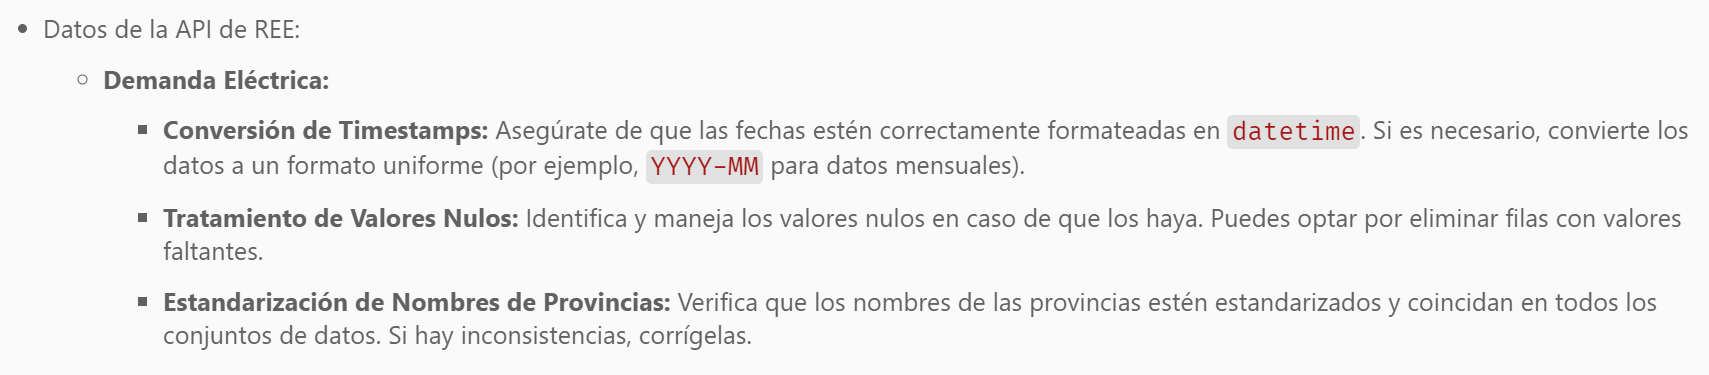

In [33]:
df_demanda.sample()

,valor,porcentaje,fecha,cod_comunidad,nombre_comunidad,anio,mes,dia
373,2357438.71,1,2020-02-01,13,Comunidad de Madrid,2020,2,1


In [31]:
df_demanda['fecha'] =  df_demanda['fecha'].apply(lambda fecha: pd.to_datetime(pd.to_datetime(fecha).strftime("%Y-%m-%d %H:%M:%S")))
df_demanda['anio'] = df_demanda['fecha'].dt.year
df_demanda['mes'] = df_demanda['fecha'].dt.month
df_demanda['dia'] = df_demanda['fecha'].dt.day

In [32]:
df_demanda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, 0 to 683
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   valor             684 non-null    float64       
 1   porcentaje        684 non-null    int64         
 2   fecha             684 non-null    datetime64[ns]
 3   cod_comunidad     684 non-null    int64         
 4   nombre_comunidad  684 non-null    object        
 5   anio              684 non-null    int32         
 6   mes               684 non-null    int32         
 7   dia               684 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2), object(1)
memory usage: 40.1+ KB


## Vemos si tenemos nulos

In [34]:
df_demanda.isna().sum()

valor               0
porcentaje          0
fecha               0
cod_comunidad       0
nombre_comunidad    0
anio                0
mes                 0
dia                 0
dtype: int64

## en principio no tenemos inconsistencias en los nombres

In [35]:
df_demanda['nombre_comunidad'].unique()

array(['Ceuta', 'Melilla', 'Andalucía', 'Aragón', 'Cantabria',
       'Castilla - La Mancha', 'Castilla y León', 'Cataluña',
       'País Vasco', 'Principado de Asturias', 'Comunidad de Madrid',
       'Comunidad Foral de Navarra', 'Comunitat Valenciana',
       'Extremadura', 'Galicia', 'Illes Balears', 'Canarias',
       'Región de Murcia', 'La Rioja'], dtype=object)

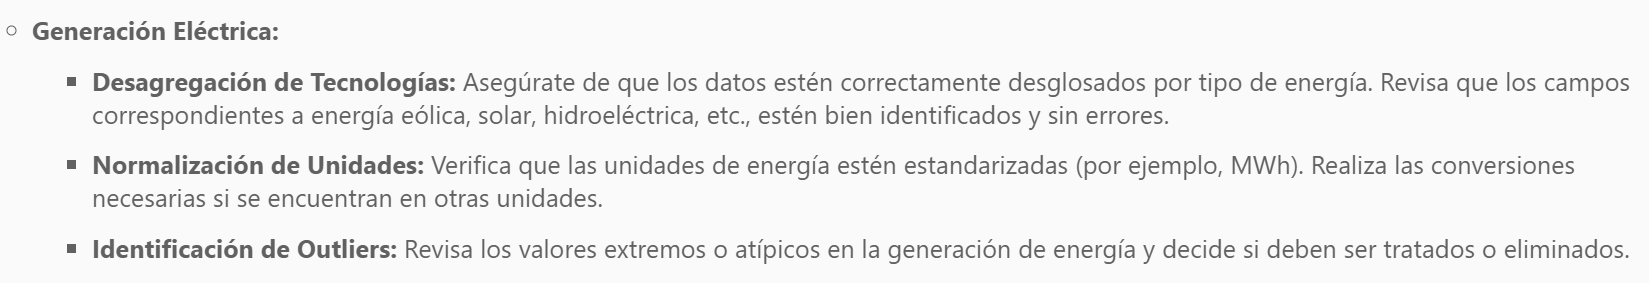

## Vemos si los campos correspondientes a la energia eolica, solar e hidroelectrica estan bien identificadas

In [36]:
df_generacion.sample()

,categoria,valor,porcentaje,fecha,color,title,last-update,cod_comunidad,nombre_comunidad,anio
2965,Hidroeólica,2218.351,0.017476,2019-09-01T00:00:00.000+02:00,#00FFFF,Hidroeólica,2020-01-10T08:42:39.000+01:00,8742,Canarias,2019


In [39]:
df_generacion['categoria'].value_counts()

categoria
Generación renovable    648
Solar fotovoltaica      647
Otras renovables        612
Hidráulica              576
Eólica                  574
Residuos renovables     249
Solar térmica           215
Hidroeólica              36
Name: count, dtype: int64

## vemos los valores atipicos

In [41]:
df_generacion.describe().T

,count,mean,std,min,25%,50%,75%,max
valor,3557.0,185537.049259,358128.907251,0.190000,7193.698000,30693.045000,178686.785000,3102351.322
porcentaje,3557.0,0.364633,0.373216,0.000002,0.035674,0.206367,0.653753,1.000
cod_comunidad,3557.0,1246.396964,3042.813710,4.000000,8.000000,13.000000,20.000000,8745.000
anio,3557.0,2020.000562,0.816726,2019.000000,2019.000000,2020.000000,2021.000000,2021.000


In [ ]:
# Detectar valores atípicos en cada columna numérica
for col in df_generacion[['']].columns:
    Q1 = df_generacion[col].quantile(0.25)
    Q3 = df_generacion[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar valores atípicos
    outliers = df_generacion[(df_generacion[col] < lower_bound) | (df_generacion[col] > upper_bound)]
    print(f"Valores atípicos en la columna {col}:")
    print(outliers[[col]])
